# Fully Connected Experiments


## 1. Setup

In [9]:
import torch
import torch.nn as nn
import semitorch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
import numpy as np
from IPython import display
from tqdm.notebook import tqdm, trange
import pandas as pd
import os
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader


data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"data path = {data_path}\ndevice = {device}")


def split_dataset(dataset: torch.utils.data.Dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

data path = /home/bmnsmets/Documents/semitorch/data
device = cuda


### Load iris data
[https://www.kaggle.com/datasets/uciml/iris](https://www.kaggle.com/datasets/uciml/iris)

In [10]:
iris_df = pd.read_csv(
    os.path.join(data_path, "iris.csv"), index_col=0, dtype={"Species": "string"}
)
iris_x = torch.Tensor(iris_df.iloc[:, [0, 1, 2, 3]].to_numpy()).to(device)


iris_y = (
    iris_df["Species"]
    .map(
        {
            "Iris-setosa": 0,
            "Iris-versicolor": 1,
            "Iris-virginica": 2,
        }
    )
    .to_numpy()
)
iris_y = torch.Tensor(iris_y).to(torch.int64).to(device)
print(
    f"Iris dataset: input features = {iris_x.shape[1]}, classes = {torch.unique(iris_y).shape[0]}, samples = {len(iris_y)}"
)

# normalize
torch.nn.functional.normalize(iris_x, dim=0, out=iris_x);

iris_train, iris_test = split_dataset(torch.utils.data.TensorDataset(iris_x, iris_y))

Iris dataset: input features = 4, classes = 3, samples = 150


### Load heart disease data

[https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset)

In [11]:
heart_df = pd.read_csv(os.path.join(data_path, "heart.csv"))
heart_x = (
    torch.Tensor(heart_df.iloc[:, range(13)].to_numpy()).to(torch.float32).to(device)
)
heart_y = torch.Tensor(heart_df.iloc[:, -1].to_numpy()).to(torch.int64).to(device)

print(
    f"Heart disease dataset: input features = {heart_x.shape[1]}, classes = {torch.unique(heart_y).shape[0]}, samples = {len(heart_y)}"
)

# normalize
torch.nn.functional.normalize(heart_x, dim=0, out=heart_x);

heart_train, heart_test = split_dataset(torch.utils.data.TensorDataset(heart_x, heart_y))

Heart disease dataset: input features = 13, classes = 2, samples = 303


### Load Naitzat data

[https://github.com/topnn/topnn_framework](https://github.com/topnn/topnn_framework)

In [12]:
circles_x, circles_y = torch.load(
    os.path.join(data_path, "naitzat", "circles_type_8.pt")
)
circles_train, circles_test = split_dataset(
    torch.utils.data.TensorDataset(circles_x, circles_y)
)
print(
    f"Circles dataset: input features = {circles_x.shape[1]}, classes = {torch.unique(circles_y).shape[0]}, samples = {len(circles_y)}"
)

rings_x, rings_y = torch.load(os.path.join(data_path, "naitzat", "rings_9.pt"))
rings_train, rings_test = split_dataset(
    torch.utils.data.TensorDataset(rings_x, rings_y)
)
print(
    f"Rings dataset: input features = {rings_x.shape[1]}, classes = {torch.unique(rings_y).shape[0]}, samples = {len(rings_y)}"
)

spheres_x, spheres_y = torch.load(os.path.join(data_path, "naitzat", "spheres_9.pt"))
spheres_train, spheres_test = split_dataset(
    torch.utils.data.TensorDataset(spheres_x, spheres_y)
)
print(
    f"Spheres dataset: input features = {spheres_x.shape[1]}, classes = {torch.unique(spheres_y).shape[0]}, samples = {len(spheres_y)}"
)

Circles dataset: input features = 2, classes = 2, samples = 15950
Rings dataset: input features = 3, classes = 2, samples = 45000
Spheres dataset: input features = 3, classes = 2, samples = 37800


## 2. Models

In [13]:
def create_model(model_name: str, num_features: int, num_classes: int):
    BACKBONE_FEATURES = 16

    if model_name == "linear_relu":
        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES),
            nn.ReLU(),
            nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
            nn.ReLU(),
        )
    elif model_name == "linear_maxplus":
        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES),
            semitorch.MaxPlus(BACKBONE_FEATURES, BACKBONE_FEATURES),
        )
    elif model_name == "linear_minplus":
        backbone = nn.Sequential(
            nn.Linear(num_features, BACKBONE_FEATURES),
            semitorch.MinPlus(BACKBONE_FEATURES, BACKBONE_FEATURES),
        )
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    head = nn.Linear(BACKBONE_FEATURES, num_classes, bias=False)

    model = nn.Sequential(OrderedDict([("backbone", backbone), ("head", head)]))

    model.name = model_name

    return model


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 3. Training

In [14]:
def accuracy(model, x, y):
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)
        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model, device, testloader):
    model.eval()
    accs = []
    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))
    return sum(accs) / len(accs)


def train(model, device, trainloader, testloader, optimizer, scheduler, loss, epochs):
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    fig, ax = plt.subplots(1, 1, figsize=[6, 4])
    hdisplay = display.display("", display_id=True)

    for epoch in trange(epochs):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))
            l = loss(yout, y)
            l.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step()

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(-0.02, 1.02)
        ax.plot(
            np.linspace(0, len(accs), len(trainaccs)),
            trainaccs,
            ".",
            markersize=1.5,
            markerfacecolor=(0, 0, 1, 0.3),
        )
        ax.plot(np.linspace(1, len(accs), len(accs)), accs)
        ax.text(
            0.6 * epochs,
            0.80,
            f"max test acc = {max(accs):.2%}",
            ha="center",
            fontsize=10,
        )
        hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    plt.close(fig)


def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    model.apply(fn=weight_reset)

In [15]:
iris_train_loader = DataLoader(iris_train, batch_size=8, shuffle=True)
iris_test_loader = DataLoader(iris_test, batch_size=len(iris_test), shuffle=False)

heart_train_loader = DataLoader(heart_train, batch_size=32, shuffle=True)
heart_test_loader = DataLoader(heart_test, batch_size=len(heart_test))

circles_train_loader = DataLoader(circles_train, batch_size=16, shuffle=True)
circles_test_loader = DataLoader(
    circles_test, batch_size=len(circles_test), shuffle=True
)

rings_train_loader = DataLoader(rings_train, batch_size=16, shuffle=True)
rings_test_loader = DataLoader(rings_test, batch_size=len(rings_test), shuffle=True)

spheres_train_loader = DataLoader(spheres_train, batch_size=16, shuffle=True)
spheres_test_loader = DataLoader(
    spheres_test, batch_size=len(spheres_test), shuffle=True
)

linear/relu model has 400 parameters
linear/maxplus model has 400 parameters


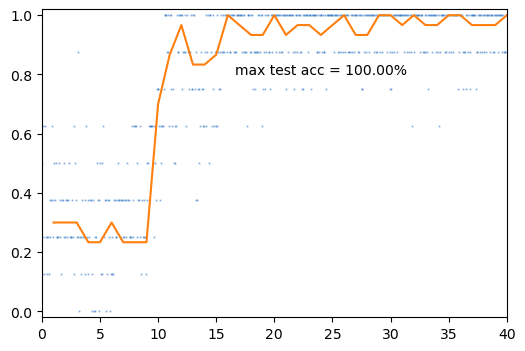

  0%|          | 0/40 [00:00<?, ?it/s]

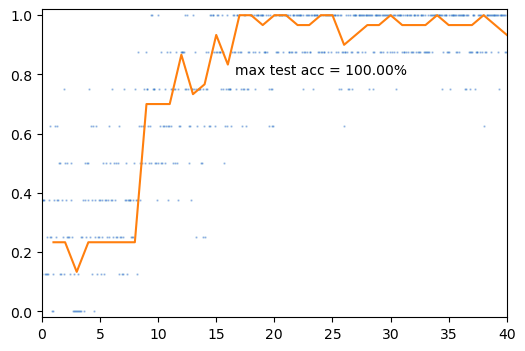

  0%|          | 0/40 [00:00<?, ?it/s]

In [16]:
linear_relu_model_iris = create_model("linear_relu", 4, 3).to(device)
print(f"linear/relu model has {count_parameters(linear_relu_model_iris)} parameters")
linear_maxplus_model_iris = create_model("linear_maxplus", 4, 3).to(device)
print(
    f"linear/maxplus model has {count_parameters(linear_maxplus_model_iris)} parameters"
)

loss = nn.CrossEntropyLoss()

epochs = 40

optimizer = torch.optim.AdamW(
    linear_relu_model_iris.parameters(), lr=2e-2, weight_decay=0.01
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-2,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(iris_train),
    epochs=epochs,
)

train(
    linear_relu_model_iris,
    device,
    iris_train_loader,
    iris_test_loader,
    optimizer,
    scheduler,
    loss,
    epochs,
)

optimizer = torch.optim.AdamW(
    linear_maxplus_model_iris.parameters(), lr=4e-2, weight_decay=0.01
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=4e-2,
    anneal_strategy="linear",
    pct_start=0.3,
    three_phase=True,
    final_div_factor=1000.0,
    div_factor=10.0,
    steps_per_epoch=len(iris_train),
    epochs=epochs,
)

train(
    linear_maxplus_model_iris,
    device,
    iris_train_loader,
    iris_test_loader,
    optimizer,
    scheduler,
    loss,
    epochs,
)